# Уравнение теплопроводности

## Одномерный случай

Хотим решить вот такую вещь:
$$U_t = U_{xx}$$

С начальными условиями:
$$
U(0, x) = \phi(x)\\
U(t, 0) = \psi(t)\\
U(t, L) = \mu(t)
$$

Итого на сетке начальные условия покрывают три грани. Значит можно использовать для решения общую схему с сигмой. Вот такую:
$$
*---*---*\\
    |\\
*---*---*
$$

Посколько из такой схемы выделить переменные адекватно нельзя, то просто сделаем одну жирную матрицу со всеми неизвестными значениями функции и решим ее.
Получим что-то такое:

$$
\frac{u^{n+1}_m - u^n_m}{\tau} = D(\sigma_1*\frac{u^n_{m+1} - 2u^n_{m} + u^n_{m-1}}{h^2_x} + (1 - \sigma_1)*\frac{u^{n+1}_{m+1} - 2u^{n+1}_{m} + u^{n+1}_{m-1}}{h^2_x}) + + (1 - \sigma_1)*f^n_m + (1 - \sigma_1)*f^{n+1}_m
$$

$$
\sigma = \sigma_1\\
\alpha = \frac{\sigma*\tau}{h^2_x}\\
\beta  = \frac{(1 - \sigma)*\tau}{h^2_x}\\
$$  

$$
u^{n+1}_m - u^n_m = D(\alpha*(u^n_{m+1} - 2u^n_{m} + u^n_{m-1}) + \beta*(u^{n+1}_{m+1} - 2u^{n+1}_{m} + u^{n+1}_{m-1}))\\
+ (1 - \sigma_1)\tau*f^n_m + (1 - \sigma_1)\tau*f^{n+1}_m
$$

In [1]:
%matplotlib notebook

In [ ]:
import math
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

In [ ]:
def identity(n):
    res = []
    for i in range(n):
        tmp = []
        for j in range(n):
            tmp.append(0)
        res.append(tmp)
    return res

def solve(N, sigma, h, tau, Ux0, U0t, ULt):
    # don't know
    alpha = sigma * tau / h**2
    beta = (1-sigma)*tau/h**2
    
    # (N^2, N^2)
    MATRIX = identity(N*N)
    B = []
    
    currentLine = 0
    
    def toMat(n, i):
        return n * N + i
    def fromMat(index):
        return (index / N, index % N)
    def insertEquation(pairs, currentLine):
        for pair in pairs:
            index, coef = pair
            MATRIX[currentLine][index] = coef
        B.append(0)
    
    #задаем значение на границе 0 за все время
    for i in range(0, N):
        MATRIX[currentLine][toMat(i, 0)] = 1
        currentLine += 1
        B.append(U0t(i * tau))
        
    #Задаем значение на границе L  за все время
    for i in range(0, N):    
        MATRIX[currentLine][toMat(i, N-1)] = 1
        currentLine += 1
        B.append(ULt(i * tau))
       
    #Задаем значение во внутрених точках в 0 время( границе не учитываем но вообще там условие связаности должно быть)
    for i in range(1, N-1):
        MATRIX[currentLine][toMat(0, i)] = 1
        currentLine += 1
        B.append(Ux0(i * h))
    
    #Задаем условие на  U(n)(m - 1),U(n)(m), U(n)(m + 1), U(n + 1)(m - 1), U(n + 1)(m), U(n + 1)(m + 1)
    for i in range(1, N-1):
        for n in range(0, N-1):
            insertEquation([
                    (toMat(n+1, i+1), beta),
                    (toMat(n+1, i), -1-2*beta),
                    (toMat(n+1,i-1), beta),
                    (toMat(n, i+1), alpha),
                    (toMat(n, i), 1-2*alpha),
                    (toMat(n, i-1), alpha)
                ], currentLine)
            currentLine += 1
    
    A = np.array(MATRIX)
    b = np.array(B)
    x = np.linalg.solve(A, b)
    
    U = [[0 for _ in range(N)] for _ in range(N)]

    for i in range(N):
        for n in range(N):
            U[n][i] = x[toMat(n, i)]
    
    return U

<IPython.core.display.Javascript object>


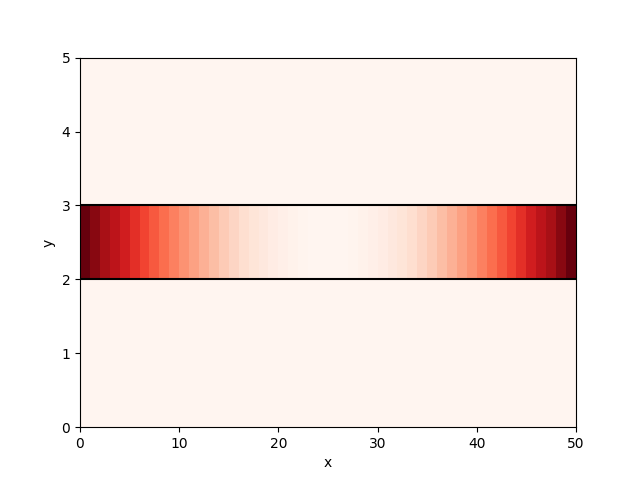

<IPython.core.display.Javascript object>


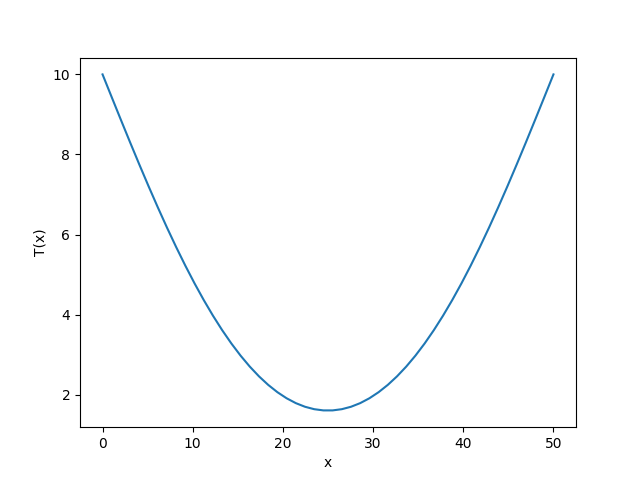

In [2]:
#строит bar
def plotrod(u_k, k, time):
    # Clear the current plot figure
    plt.clf()

    #plt.xlabel("x")
    #plt.ylabel("T(x)")

    # This is to plot u_k (u at time-step k)
    #plt.plot(k, u_k, label = "time = " + str(time))
    #plt.legend()
    
    
    plt.xlabel("x")
    plt.ylabel("y")
    # 4 белых полоски и посередине наш градиентик
    tmp = [[0 for _ in range(len(u_k))], [0 for _ in range(len(u_k))], u_k, [0 for _ in range(len(u_k))], [0 for _ in range(len(u_k))]]
    plt.pcolormesh(tmp, cmap="Reds", vmin=np.min(u_k), vmax=np.max(u_k))
    plt.plot([0, max(k)], [2, 2], color = "black")
    plt.plot([0, max(k)], [3, 3], color = "black")
    
    return plt

# Строит график
def plotgraph(u_k, k, time):
    # Clear the current plot figure
    plt.clf()

    plt.xlabel("x")
    plt.ylabel("T(x)")

    # This is to plot u_k (u at time-step k)
    plt.plot(k, u_k)
    
    return plt


def draw(N, sigma, h, tau, Ux0, U0t, ULt):
    u = solve(N, sigma, h, tau, Ux0, U0t, ULt)
    xs = np.linspace(0, N * h, N)
#     print(u)
    max_iter_time = 750
    anim = animation.FuncAnimation(plt.figure(), lambda k: plotrod(u[k % N], xs, k), interval=1, frames=max_iter_time, repeat=True)
    anim.save('animation1.gif', fps=25)
    plt.show()
    anim = animation.FuncAnimation(plt.figure(), lambda k: plotgraph(u[k % N], xs, k), interval=1, frames=max_iter_time, repeat=True)
    plt.show()
    anim.save('animation2.gif', fps=25)

def Ux01(x):
    return math.exp(-x**2)
def U0t1(t):
    return 1/math.sqrt(1+4*t)
def ULt1(t):
    return math.exp(-1/(1+4*t)) / math.sqrt(1+4*t)
def uTrue(t, x):
    return 1/math.sqrt(1+4*t) * math.exp(-x**2 / (1+4*t))


def getInfl(N, sigma, h, tau):
    u = solve(N, sigma, h, tau, Ux01, U0t1, ULt1)

    res = 0
    
    for i in range(N):
        for n in range(N):
            res = max(res, math.fabs(u[n][i] - uTrue(n * tau, i * h)))
            
    return res

def calcInfls(sigma, N):
    infls = []
    if sigma > 0.5:
        sigma = 0.5
    for n in range(5, N):
        infls.append(math.log(getInfl(n, sigma, 1.0/n, 1.0/n)))
        
    if sigma == 0.5:
        return np.array(infls) * 2
    return np.array(infls)

def drawInfls(N):
    ns = [math.log(n) for n in range(5, N)]
    infls1 = calcInfls(0, N)
    infls2 = calcInfls(0.5, N)
    infls3 = calcInfls(1, N)

    fig, ax = plt.subplots()
    
    ax.plot(ns, infls1, label = "sigma = 0")
    ax.plot(ns, infls2, label = "sigma = 0.5")
    ax.plot(ns, infls3, label = "sigma = 1")

    print(round(-(infls1[-1]-infls1[0])/(ns[-1]-ns[0])))
    print(round(-(infls2[-1]-infls2[0])/(ns[-1]-ns[0])))
    print(round(-(infls3[-1]-infls3[0])/(ns[-1]-ns[0])))

    plt.legend()
    plt.show()

def Ux0(x):
    return 0
def U0t(t):
    return 10
def ULt(t):
    return 10

h = 1
tau = 2
N = 20
sigma = 0

draw(N, sigma, h, tau, Ux0, U0t, ULt)
#drawInfls(20)

<IPython.core.display.Javascript object>


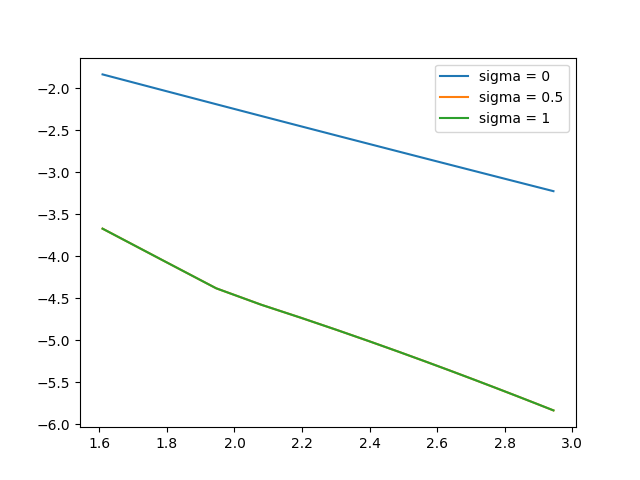

1
2
2


In [4]:
drawInfls(20)

| sigma = 0 approximation | sigma = 0.5 approximation | sigma = 1 approximation |
|---------------------------------|---------------------- ---|------------------------------------|
| 1 | 2 | 2 |

## Двумерный случай

Используем вот такую схему:
![Scheme](164059197-bfabc474-1a2d-4d7d-9fd0-c00a76944c1c.png)
Это явная схема крест она не устойчива

$$
\frac{u^{n+1}_{m, k} - u^n_{m, k}}{\tau} = \alpha(\frac{u^n_{m+1, k} - 2u^n_{m, k} + u^n_{m-1, k}}{h^2_x} + \frac{u^{n}_{m, k + 1} - 2u^{n}_{m, k} + u^{n}_{m, k-1}}{h^2_y}) + f^n_{m, k}
$$

$$
u^{n+1}_{m, k} - u^n_{m, k} = \gamma_1(u^n_{m+1, k} - 2u^n_{m, k} + u^n_{m-1, k}) + \gamma_2(u^{n}_{m, k + 1} - 2u^{n}_{m, k} + u^{n}_{m, k-1}) + f^n_{m, k}
$$

<IPython.core.display.Javascript object>


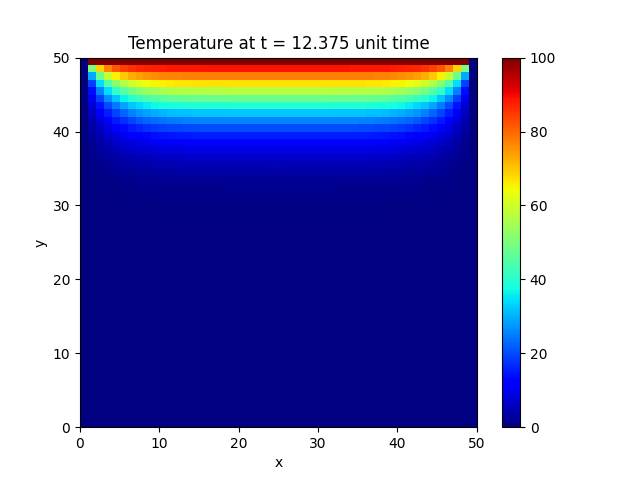

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

plate_length = 50
max_iter_time = 100

alpha = 2
delta_x = 1

# for sustainability
delta_t = (delta_x ** 2)/(4 * alpha)
gamma = (alpha * delta_t) / (delta_x ** 2)

# Initialize solution: the grid of u(k, i, j)
u = np.empty((max_iter_time, plate_length, plate_length))

# Initial condition everywhere inside the grid
u_initial = 0

# Boundary conditions
u_top = 100.0
u_left = 0.0
u_bottom = 0.0
u_right = 0.0

# Set the initial condition
u.fill(u_initial)

# Set the boundary conditions
u[:, (plate_length-1):, :] = u_top
u[:, :, :1] = u_left
u[:, :1, 1:] = u_bottom
u[:, :, (plate_length-1):] = u_right

def calculate(u):
    for k in range(0, max_iter_time-1, 1):
        for i in range(1, plate_length-1, delta_x):
            for j in range(1, plate_length-1, delta_x):
                u[k + 1, i, j] = gamma * (u[k][i+1][j] + u[k][i-1][j] + u[k][i][j+1] + u[k][i][j-1] - 4*u[k][i][j]) + u[k][i][j]

    return u

def plotheatmap(u_k, k):
    # Clear the current plot figure
    plt.clf()

    plt.title(f"Temperature at t = {k*delta_t:.3f} unit time")
    plt.xlabel("x")
    plt.ylabel("y")

    # This is to plot u_k (u at time-step k)
    plt.pcolormesh(u_k, cmap=plt.cm.jet, vmin=0, vmax=100)
    plt.colorbar()

    return plt

# Do the calculation here
u = calculate(u)

def animate(k):
    plotheatmap(u[k], k)

anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=max_iter_time, repeat=False)
anim.save("heat_equation_solution.gif")